In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
import statsmodels as sm
import statsmodels.api as sma

loc = 'workstation'
if loc == 'laptop':
    #eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/student_projects/EffortDifficulty/analysis/tools'
    eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/tools'
    wd         = '/Users/sammichekroud/Desktop/postdoc/wmconfidence' #working on confidence data, but in postdoc dir
elif loc == 'workstation':
    eyefuncdir = 'C:/Users/sammirc/Desktop/postdoc/tools/'
    wd         =  'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
    funcdir    = op.join(wd, 'analysis', 'tools')
    sys.path.insert(0, funcdir)
os.chdir(wd)
# sys.path.insert(0, eyefuncdir)
sys.path.insert(0, op.join(wd, 'analysis', 'tools'))

from funcs import getSubjectInfo, clusterperm_test

eyedir = op.join(wd, 'data', 'eyes')
bdir   = op.join(wd, 'data', 'datafiles')

subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26]) #eeg ppts
# subs = np.array([         4, 5, 6, 7, 8, 9,             13, 14, 15,     17,         20, 21, 22,     24, 25, 26]) # eyetracking ppts
nsubs = subs.size
#set some params here
modeltimes = np.load(op.join(wd, 'data', 'tuningcurves', '500hz', 'times_500hz.npy'))
#doing a median split on each participant by their single-trial error, so we need two levels of a dimension of the array
prec = np.zeros(shape = [nsubs, 2, modeltimes.size]) * np.nan
amp  = np.zeros(shape = [nsubs, 2, modeltimes.size]) * np.nan

In [3]:
subcount = -1
print('looping over participants and modelling')
for sub in subs:
    subcount += 1 
    binstep, binwidth = 4, 22
    
    #read in modelled tuning curve parameters
    alpha = np.load(op.join(wd, 'data', 'tuningcurves', '500hz', 'parameter_fits', 'twostage_alphaminmaxfit',
                f's{sub}_ParamFits_precision_binstep{binstep}_binwidth{binwidth}.npy'))
    ampglm = np.load(op.join(wd, 'data', 'tuningcurves', '500hz', 'parameter_fits', 'twostage_alphaminmaxfit',
                f's{sub}_ParamFits_amplitude_binstep{binstep}_binwidth{binwidth}_glmfit.npy'))
    
    #note here precision is modelled in the same way, but amplitude is modelled with a constrained alpha (min 0.001), and minmax-scaled design matrix for the glmfit. optimised fit doesnt have to scale the design matrix
    tcbdata = pd.read_csv(op.join(wd, 'data', 'tuningcurves', f's{sub}_TuningCurve_metadata.csv')) #read in associated behavioural data
    #metadata doesnt have the behavioural preproc output
    tcbdata = tcbdata.assign(trlid = np.where(tcbdata.session.eq('a'), tcbdata.trialnum, tcbdata.trialnum+256))
    
    #so lets grab the file that does
    isub = dict(loc = loc, id = sub); param = getSubjectInfo(isub)
    bdata = pd.read_csv(op.join(param['path'], 'datafiles', f's{sub:02d}', f'wmConfidence_S{sub:02d}_gathered_preprocessed.csv')) #has full behavioural preproc done
    bdata = bdata.assign(trlid = np.where(bdata.session.eq('a'), bdata.trialnum, bdata.trialnum+256)) #get trialnumber
    bdata = bdata.query('trlid in @tcbdata.trlid') #take just the trials used in the tuning curve decomposition
    
    #drop trials with slow RTs (more than 2.5sds from the ppt mean)
    dt = bdata.DT.to_numpy()
    meandt = dt.mean() #mean decision time
    sd_dt  = dt.std() #std deviation of decision times
    dtcheck = np.logical_or(np.greater(dt, meandt + 3*sd_dt), np.less(dt, meandt - 3*sd_dt)) #mark as 1 if discard
    dtcheck = np.greater(dt, meandt + 3*sd_dt)
    bdata = bdata.assign(DTcheck = dtcheck) #reassign dtcheck so it's across all trials of the participant, not within cue condition
    keeptrls = dtcheck == 0 #mark if keeping a trial
    
    #discard trials that are too slow
    alpha  = alpha[:,keeptrls]
    ampglm = ampglm[:,keeptrls]
    bdata  = bdata.iloc[keeptrls]
    
    #exclude trials with over 60 degrees of error
    # keeptrls = bdata.absrdif.le(60).to_numpy()
    # alpha = alpha[:, keeptrls]
    # ampglm = ampglm[:,keeptrls]
    # bdata = bdata.query('absrdif <= 60')
    
    [nitems, ntrials, _, ntimes] = alpha.shape #get some feature dimensions
    #get things
    pitem = bdata.pside.to_numpy() #vector describing which side the subsequently probed item was on. 0 = left, 1 = right item
    error = bdata.absrdif.to_numpy() #absolute angular error on a given trial
    
    #get precision and amplitude of the item that was actually probed - lets us test if precision/amplitude of the representation of the item that was actually reported is relevant for behaviour
    itemprec = np.zeros(shape = [ntrials, ntimes]) * np.nan
    itemamp = np.zeros(shape = [ntrials, ntimes]) * np.nan
    for itrl in range(ntrials):
        ipside = pitem[itrl]
        itemprec[itrl] = alpha[ipside, itrl, 0] #keep just the parameter estimate of precision
        itemamp[itrl]  = ampglm[ipside, itrl, 0] #keep just the parameter estimate
    
    mederr = np.median(error)
    belowmed = np.less_equal(error, mederr)
    abovemed = np.greater(error, mederr)
    
    #average across trials
    goodprec, badprec = itemprec[belowmed].mean(0), itemprec[abovemed].mean(0)
    goodamp, badamp = itemamp[belowmed].mean(0), itemamp[abovemed].mean(0)
    
    prec[subcount] = [goodprec, badprec]
    amp[subcount]  = [goodamp, badamp]
print('done')

looping over participants and modelling
done


In [4]:
labels = ['accurate', 'inaccurate']
colors = ['#3182bd', '#756bb1']
prec_mean, prec_sem = prec.mean(0), sp.stats.sem(prec, axis=0, ddof = 0)
amp_mean, amp_sem   = amp.mean(0),  sp.stats.sem(amp,  axis=0, ddof= 0)

prec_diff = np.subtract(prec[:,0], prec[:, 1])
precdiff_mean, precdiff_sem = prec_diff.mean(0), sp.stats.sem(prec_diff, axis=0, ddof=0)

amp_diff = np.subtract(amp[:,0], amp[:, 1])
ampdiff_mean, ampdiff_sem = amp_diff.mean(0), sp.stats.sem(amp_diff, axis=0, ddof=0)

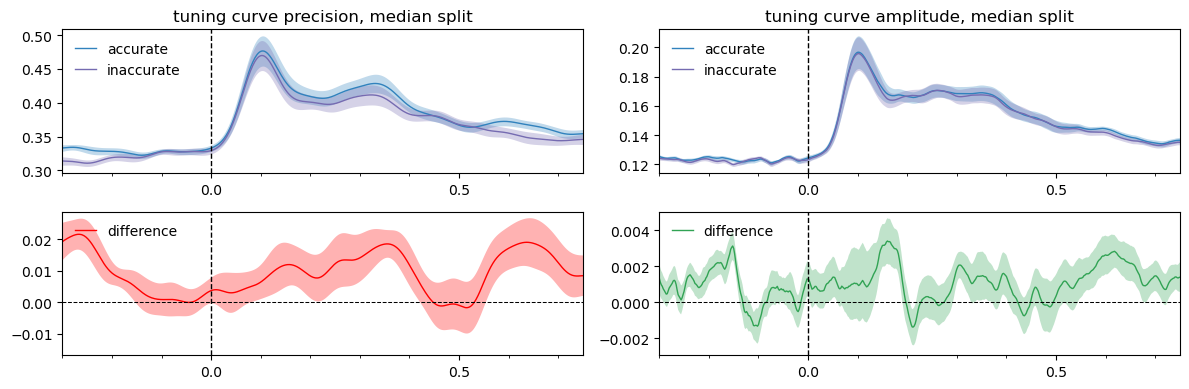

In [5]:
fig = plt.figure(figsize = [12,4])
ax = fig.add_subplot(221)
for iparam in range(2):
    ax.plot(modeltimes, prec_mean[iparam], lw = 1, color = colors[iparam], label = labels[iparam])
    ax.fill_between(modeltimes, np.add(prec_mean[iparam], prec_sem[iparam]), np.subtract(prec_mean[iparam], prec_sem[iparam]),
                    lw = 0, edgecolor = None, alpha= 0.3, color = colors[iparam])
ax.axvline(0, ls = 'dashed', lw = 1, color='k')
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True);
ax.set_xlim([-0.3, 0.75])
ax.set_title('tuning curve precision, median split')
ax.legend(loc = 'upper left', frameon=False, handlelength = 1.5)

ax = fig.add_subplot(222)
for iparam in range(2):
    ax.plot(modeltimes, amp_mean[iparam], lw = 1, color = colors[iparam], label = labels[iparam])
    ax.fill_between(modeltimes, np.add(amp_mean[iparam], amp_sem[iparam]), np.subtract(amp_mean[iparam], amp_sem[iparam]),
                    lw = 0, edgecolor = None, alpha= 0.3, color = colors[iparam])
ax.axvline(0, ls = 'dashed', lw = 1, color='k')
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True);
ax.set_xlim([-0.3, 0.75])
ax.legend(loc = 'upper left', frameon=False, handlelength = 1.5)
ax.set_title('tuning curve amplitude, median split')

ax = fig.add_subplot(223)
ax.plot(modeltimes, precdiff_mean, lw = 1, color = 'r', label = 'difference')
ax.fill_between(modeltimes, np.add(precdiff_mean, precdiff_sem), np.subtract(precdiff_mean, precdiff_sem), lw = 0, color = 'r', alpha = 0.3, edgecolor=None)
ax.axvline(0, ls = 'dashed', lw = 1, color='k')
ax.axhline(0, ls = 'dashed', lw = 0.75, color = 'k')
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True);
ax.set_xlim([-0.3, 0.75])
ax.legend(loc = 'upper left', frameon=False, handlelength = 1.5)

ax = fig.add_subplot(224)
ax.plot(modeltimes, ampdiff_mean, lw = 1, color = '#31a354', label = 'difference')
ax.fill_between(modeltimes, np.add(ampdiff_mean, ampdiff_sem), np.subtract(ampdiff_mean, ampdiff_sem), lw = 0, color = '#31a354', alpha = 0.3, edgecolor=None)
ax.axvline(0, ls = 'dashed', lw = 1, color='k')
ax.axhline(0, ls = 'dashed', lw = 0.75, color = 'k')
ax.set_xticks(np.arange(-0.5, 1.5, 0.5))
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True);
ax.set_xlim([-0.3, 0.75])
ax.legend(loc = 'upper left', frameon=False, handlelength = 1.5)


fig.tight_layout()